In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import os
import pathlib
# tensorflow 2.

# Run in anaconda prompt first:
# conda install -c conda-forge librosa
import librosa
import librosa.display

#from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tensorflow import keras 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.metrics import confusion_matrix, classification_report


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Make sure you have the following files in the same directory as this ipynb:
# 1. nsynth-test.tfrecord
# 2. nsynth-train.tfrecord
# 3. nsynth-valid.tfrecord

nsynth_test = tf.data.TFRecordDataset(['nsynth-test.tfrecord'], num_parallel_reads=2)
nsynth_train = tf.data.TFRecordDataset(['nsynth-train.tfrecord'], num_parallel_reads=2).shuffle(10000, seed=123)
nsynth_valid = tf.data.TFRecordDataset(['nsynth-valid.tfrecord'], num_parallel_reads=2)

/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [4]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord#read_the_tfrecord_file

def get_features(record):
    # We're only going to use a few features for now
    features = {
        # identifier string, this will be our label
        #"note_str": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        # MIDI tuning standard value for pitch
        "pitch": tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
        # list of normalized audio 'samples' to represent the sound wave
        "audio": tf.io.FixedLenFeature(shape=[64000], dtype=tf.float32)
    }
    sample = tf.io.parse_single_example(record, features)
    
    return sample

In [5]:
# num classes in set of 1529 samples: 109 (without standardizing to 128 classes)
test_ds = list(nsynth_test.take(4000).map(get_features))

In [6]:
# Note about how our audio feature is structured:
#
# 4 seconds * 16000 samples per second = 64000 samples
# We only have one channel (these sound clips are mono)
# Dynamic range of 16-bit PCM WAV (-2^15, 2^15 - 1) normalized to (-1, 1)


# We get the first sample in our test dataset as an example
clip1 = test_ds[0]['audio']
clip1

<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 3.8138387e-06, -3.8721851e-06,  3.9331076e-06, ...,
       -3.6526076e-06,  3.7041993e-06, -3.7578957e-06], dtype=float32)>

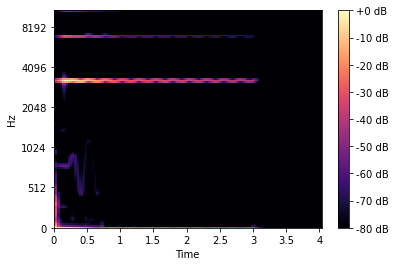

In [7]:
# A mel spectrogram. A spectrogram visualizes a signal's amplitude at different 
# frequencies over time. The mel scale is used because human perception of pitch
# is not linear. We use the mel scale because we want to retrieve the 
# Mel-frequency Cepstral Coefficients (MFCCs).
sample_rate = 16000
S = librosa.feature.melspectrogram(np.array(clip1), sr=sample_rate, n_fft=2048, hop_length=512)

# amplitude to decibels, relative to maximum value in audio clip
S_DB = librosa.power_to_db(S, ref=np.max)

# plot
librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

(13, 126)

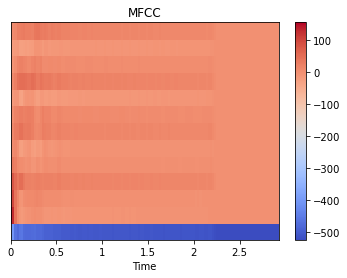

In [8]:
# try getting mfccs with librosa, see below for tensorflow version

MFCC = librosa.feature.mfcc(np.array(clip1), sr=sample_rate, n_mfcc=13)
fig, ax = plt.subplots()
img = librosa.display.specshow(MFCC, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')
MFCC.shape

/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(13, 126)

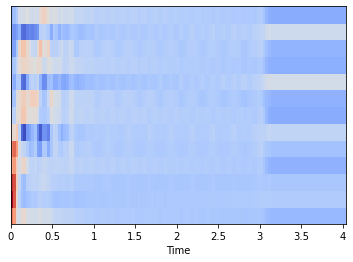

In [9]:
# scaled mfccs
from sklearn import preprocessing as pre

MFCC = pre.scale(MFCC, axis=1)
librosa.display.specshow(MFCC, sr=sample_rate, x_axis='time')
MFCC.shape

In [12]:
def midi_pitch_to_frequency(d):
    return (2**((d-69)/12.0))*440.0

from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def frequency_to_note(freq):
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

def midi_pitch_to_note(d):
    return frequency_to_note(midi_pitch_to_frequency(d))

f = midi_pitch_to_frequency(100)
print("Frequency: ", f)
print("Note: ", frequency_to_note(f))


Frequency:  2637.02045530296
Note:  E7


In [13]:
test_note = test_ds[0]['pitch']
test_note
# We can observe a few things from the previous 3 results:

# 1. Our first audio clip has midi pitch value 100, which encodes the note E7. 
# 2. The note E7 has the fundamental frequency 2637 Hz.
# 3. The spectogram above has frequency ~2700 Hz most represented.

<tf.Tensor: shape=(), dtype=int64, numpy=100>

In [14]:
# https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms
# https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

def to_mfccs(audio_array):
    return librosa.feature.mfcc(audio_array, sr=sample_rate, n_mfcc=40).flatten()

def to_mfccs_noflatten(audio_array):
    return librosa.feature.mfcc(audio_array, sr=sample_rate, n_mfcc=40)

# result: we go from 64,000 samples to 247x20 coefficients. 
# huge reduction in feature space!

In [15]:
# Trim 289,205 training samples down to at least 20,000
# Too many samples takes too long to load and uses a lot of RAM

# num classes in set of 20000 samples: 110 (without standardizing to 128 classes)
train_ds = list(nsynth_train.take(20000).map(get_features))

# num classes in set of 9000 sample: 109 (without standardizing to 128 classes)
#train_ds = list(nsynth_train.take(9000).map(get_features))

/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [16]:
sample_rate = 16000
# We trimmed 4096 test samples down to 1000 
# X terms for train and test are used for SVM, the Y terms will be used for all models

y_test = [test_ds[i]['pitch'].numpy() for i in range(len(test_ds))]
x_test = [to_mfccs(test_ds[i]['audio'].numpy()) for i in range(len(test_ds))]

y_train = [train_ds[i]['pitch'].numpy() for i in range(len(train_ds))]
x_train = [to_mfccs(train_ds[i]['audio'].numpy()) for i in range(len(train_ds))]

In [58]:
#svm_clf = SVC()
#svm_clf.fit(x_train, y_train)
#svm_y_predict = svm_clf.predict(x_test)

In [59]:
#print(classification_report(y_test, svm_y_predict))

              precision    recall  f1-score   support

           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         4
          19       0.00      0.00      0.00         3
          20       0.00      0.00      0.00         3
          21       0.03      0.32      0.06        25
          22       0.08      0.03      0.04        34
          23       0.00      0.00      0.00        35
          24       0.00      0.00      0.00        39
          25       0.05      0.18      0.08        39
          26       0.00    

/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# x_train_nf = [to_mfccs_noflatten(train_ds[i]['audio'].numpy()) for i in range(len(train_ds))]
# x_test_nf = [to_mfccs_noflatten(test_ds[i]['audio'].numpy()) for i in range(len(test_ds))]

# x_train_nf = np.asarray(x_train_nf)
# x_test_nf = np.asarray(x_test_nf)

# # only used for first CNN
# y_train_ar = np.asarray(y_train)

In [18]:
valid_ds = list(nsynth_valid.take(4000).map(get_features))
y_val = [valid_ds[i]['pitch'].numpy() for i in range(len(valid_ds))]

In [14]:
# x_val_nf = [to_mfccs_noflatten(valid_ds[i]['audio'].numpy()) for i in range(len(valid_ds))]
# x_val_nf = np.asarray(x_val_nf)

# # only used for first CNN
# y_val_ar = np.asarray(y_val)

In [41]:
# from numpy import newaxis
# x_val3d = x_val_nf[:, :, :, newaxis]
# x_val3d[0].shape

(40, 126, 1)

In [42]:
# x_train3d = x_train_nf[:, :, :, newaxis]
# x_train3d[0].shape

(40, 126, 1)

In [19]:
from keras.utils import to_categorical

y_train_1hot = to_categorical(y_train, num_classes=128)
y_test_1hot  = to_categorical(y_test, num_classes=128)
y_val_1hot = to_categorical(y_val, num_classes=128)
len(y_train_1hot[0])

128

In [20]:
def to_log_melspectogram(audio_array):
    sample_rate = 16000
    S = librosa.feature.melspectrogram(audio_array, sr=sample_rate, n_fft=2048, hop_length=512)
    # decibels are the log scale of amplitudes
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

In [21]:
x_train_logmel = [to_log_melspectogram(train_ds[i]['audio'].numpy()) for i in range(len(train_ds))]
x_test_logmel = [to_log_melspectogram(test_ds[i]['audio'].numpy()) for i in range(len(test_ds))]
x_val_logmel = [to_log_melspectogram(valid_ds[i]['audio'].numpy()) for i in range(len(valid_ds))]

x_train_logmel = np.asarray(x_train_logmel)
x_test_logmel = np.asarray(x_test_logmel)
x_val_logmel = np.asarray(x_val_logmel)

In [23]:
from numpy import newaxis
x_train_logmel = x_train_logmel[:, :, :, newaxis]
x_test_logmel = x_test_logmel[:, :, :, newaxis]
x_val_logmel = x_val_logmel[:, :, :, newaxis]

In [24]:
from keras.layers import LeakyReLU
from keras.layers import advanced_activations

input_shape = x_train_logmel[0].shape

num_labels = 128

norm_layer = preprocessing.Normalization()
norm_layer.adapt(x_train_logmel)

model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,  
    layers.Conv2D(filters = 32, kernel_size = (5,5), strides = (2,2), activation='relu', padding = 'valid'),
    layers.Conv2D(filters = 64, kernel_size = (5,5), activation='relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation = 'softmax'),
])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 128, 126, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 61, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 61, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59520)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    x_train_logmel, 
    y_train_1hot, 
    validation_data= (x_val_logmel, y_val_1hot),  
    batch_size = 128,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
 13/157 [=>............................] - ETA: 7:46 - loss: 4.9830 - accuracy: 0.0228

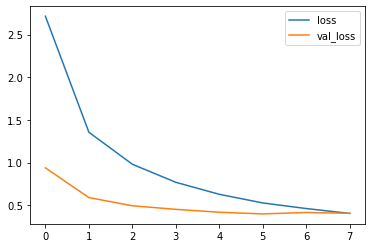

In [141]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [145]:
y_pred = np.argmax(model.predict(x_test_logmel), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)

print(f'Test set accuracy: {test_acc:.0%}')

test_loss, test_acc = model.evaluate(x_test_logmel,  y_test_1hot, verbose=2)
print('\nTest accuracy for CNN:', '{:.2%}'.format(test_acc))

Test set accuracy: 86%
125/125 - 29s - loss: 0.7996 - accuracy: 0.8572

Test accuracy for CNN: 85.72%


In [100]:
cnn_cm = confusion_matrix(y_test, y_pred)
mycolumns = ["Target: " + midi_pitch_to_note(i) for i in range(10,116)]
myindices = ["Predict: " + midi_pitch_to_note(i) for i in range(10,116)]
cnn_cm_df = pd.DataFrame(cnn_cm, index=myindices, columns=mycolumns)
cnn_cm_df

,Target: A#-1,Target: B-1,Target: C0,Target: C#0,Target: D0,Target: D#0,Target: E0,Target: F0,Target: F#0,Target: G0,...,Target: A#7,Target: B7,Target: C8,Target: C#8,Target: D8,Target: D#8,Target: E8,Target: F8,Target: F#8,Target: G8
Predict: A#-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: B-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: C0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: C#0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: D0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Predict: D#8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: E8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: F8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: F#8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         4
          19       0.00      0.00      0.00         3
          20       0.00      0.00      0.00         3
          21       0.12      0.04      0.06        25
          22       0.08      0.06      0.07        34
          23       0.22      0.11      0.15        35
          24       0.00      0.00      0.00        39
          25       0.00      0.00      0.00        39
          26       0.12    

/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After initial rounds of testing, Documented testing took place:

Trail 1:
* Train 20,000 samples
* Test 1,000 samples
* Validation 5,000 samples
* With Early Stopping
* Ran 3 EPOCHS with Accuracy of 58%
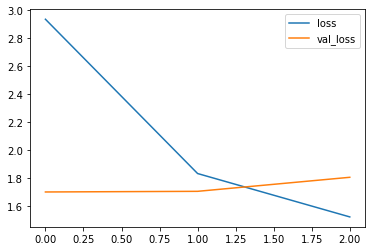

Trail 2:
* Train 20,000 samples
* Test 1,000 samples
* Validation 5,000 samples
* With NO Early Stopping
* ~20 minutes to train model
* Ran 3 EPOCHS with Accuracy of 61%
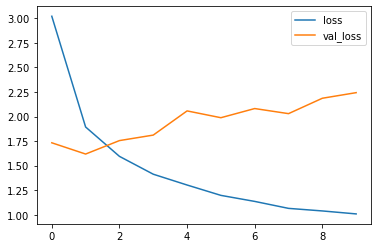

Trail 3:
* Train 20,000 samples
* Test 1,000 samples
* Validation 1,000 samples
* With Early Stopping
* ~14 minutes to train model
* Ran 7 EPOCHS with Accuracy of 62%
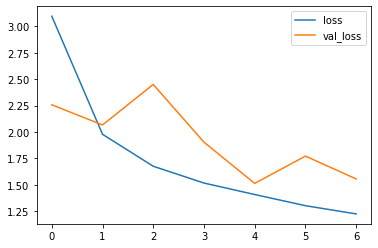

In [64]:
# Convolutional Neural Network Attempt
from keras.optimizers.schedules import ExponentialDecay

norm_layer = preprocessing.Normalization()
norm_layer.adapt(x_train_logmel)

cnn1 = keras.Sequential([
    layers.InputLayer(input_shape=x_train_logmel[0].shape),
    norm_layer,  
    layers.Conv2D(filters=32, 
                  kernel_size=(5,5),
                  activation='relu',
                  padding='valid',
                  strides=(2,2)),
    layers.Conv2D(filters=64,
                  kernel_size=(3,3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(y_train_1hot[0]), activation='softmax')
])

#schedule1 = ExponentialDecay(initial_learning_rate=0.5, decay_steps=2000, decay_rate=0.95)
amsgrad = keras.optimizers.Adam(amsgrad=True)
cnn1.compile(optimizer=amsgrad, loss='categorical_crossentropy', metrics=['accuracy'])
cnn1.fit(x_train_logmel, y_train_1hot, 
         batch_size=32, 
         epochs=5, 
         validation_data=(x_val_logmel, y_val_1hot), 
         callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/5
625/625 [==============================] - 168s 268ms/step - loss: 1.3870 - accuracy: 0.6722 - val_loss: 0.4437 - val_accuracy: 0.8870
Epoch 2/5
625/625 [==============================] - 169s 270ms/step - loss: 0.4101 - accuracy: 0.8747 - val_loss: 0.4319 - val_accuracy: 0.8863
Epoch 3/5
625/625 [==============================] - 171s 273ms/step - loss: 0.2168 - accuracy: 0.9337 - val_loss: 0.4776 - val_accuracy: 0.8790
Epoch 4/5
625/625 [==============================] - 174s 279ms/step - loss: 0.1353 - accuracy: 0.9592 - val_loss: 0.4815 - val_accuracy: 0.9035
Epoch 00004: early stopping


In [65]:
test_loss, test_acc = cnn1.evaluate(x_test_logmel,  y_test_1hot, verbose=2)
print('\nTest accuracy for CNN1:', '{:.2%}'.format(test_acc))

125/125 - 8s - loss: 1.0563 - accuracy: 0.8375

Test accuracy for CNN1: 83.75%


In [66]:
cnn1.save('nsynth_cnn_classifier.h5')

In [67]:
cnn1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_16 (Normalizat (None, 128, 126, 1)       3         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 62, 61, 32)        832       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 62, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 30, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 31, 30, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 59520)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)             